使用Wind金融数据库的数据，编写的pandas版指标计算逻辑？

我在CMB的半年都写了些什么狗屎啊。。。

In [2]:
w.isconnected()

True

In [3]:
import matplotlib.pyplot as plt

In [4]:
DT = date(2022,1,14)                           # T-1天
BDT = DT - timedelta(days = 364)
FT = date(2020,1,1)

In [5]:
riskfree = w.edb("S0059744", FT, DT, usedf=True)[1].reset_index()
riskfree.columns = ['date', 'riskfree']
benchmark = w.wsd("885061.WI", "pct_chg", FT, DT, "", usedf=True)[1].reset_index()
benchmark.columns = ['date', 'benchmark']
nav000126 = w.wsd("000126.OF", "nav,NAV_acc,NAV_adj,NAV_adj_return1", FT, DT, "", usedf=True)[1].reset_index()
nav000126.columns = ['date', 'nav', 'acc_nav', 'adj_nav', 'adj_pctchg']

In [13]:
nav = nav000126.merge(benchmark).merge(riskfree)
nav['code'] = '000126.OF'
nav = nav.set_index(['code']).sort_values('date',ascending=False)
nav['riskfree'] = ((nav['riskfree'] / 100 + 1) ** (1.0 / 250) - 1) * 100
# nav['riskfree'] = nav['riskfree'] / sqrt(250)
nav

,date,nav,acc_nav,adj_nav,adj_pctchg,benchmark,riskfree
code,,,,,,,
000126.OF,2022-01-14,3.8071,4.1511,5.116784,2.064288,0.131143,0.008596
000126.OF,2022-01-13,3.7301,4.0741,5.013295,-1.723093,-1.297189,0.008631
000126.OF,2022-01-12,3.7955,4.1395,5.101194,3.801449,1.037650,0.008665
000126.OF,2022-01-11,3.6565,4.0005,4.914376,-1.572048,-0.910612,0.008688
000126.OF,2022-01-10,3.7149,4.0589,4.992866,-0.742779,0.251354,0.008761
...,...,...,...,...,...,...,...
000126.OF,2020-01-08,1.4467,1.7907,1.944381,-0.508906,-0.654414,0.009096
000126.OF,2020-01-07,1.4541,1.7981,1.954326,1.225200,0.626955,0.009593
000126.OF,2020-01-06,1.4365,1.7805,1.930672,0.984183,0.126821,0.009534


In [14]:
navy = nav[nav['date'] > date(2021,1,13)]

,date,acc_return,acc_bench,acc_ex
code,,,,
000126.OF,2022-01-14,37.10,3.21,33.89
000126.OF,2022-01-13,34.33,3.08,31.25
000126.OF,2022-01-12,36.69,4.43,32.25
000126.OF,2022-01-11,31.68,3.36,28.32
000126.OF,2022-01-10,33.78,4.31,29.47
...,...,...,...,...
000126.OF,2021-01-21,6.59,2.54,4.06
000126.OF,2021-01-20,4.55,1.39,3.16
000126.OF,2021-01-19,0.42,0.17,0.25


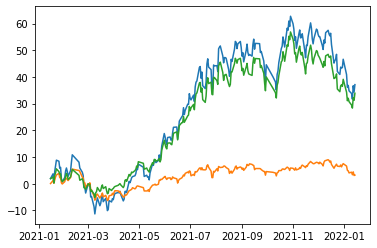

In [175]:
# 累计收益
def period_return(nav):
    date = nav['date'][:-1]
    acc_return = (nav['adj_nav'][:-1] / nav['adj_nav'][-1] - 1) * 100
    plt.plot(date, acc_return)
    acc_bench = ((1 + nav['benchmark'][:-1] / 100)[::-1].cumprod()[::-1] - 1) * 100
    plt.plot(date, acc_bench)
    acc_ex = acc_return - acc_bench
    plt.plot(date, acc_ex)
    return round(pd.DataFrame({'date':date, 'acc_return':acc_return, 'acc_bench':acc_bench, 'acc_ex':acc_ex}), 2).fillna(0)
period_return(navy)

In [182]:
# 年化总收益
def rp(nav):
    rpt = (nav['adj_nav'][0] / nav['adj_nav'][-1] - 1) * 100
    rpa = ((rpt / 100 + 1) ** (250 / (nav[:-1].count()[0])) - 1) * 100
    return round(rpt, 2), round(rpa, 2)
rp(navy)

(37.1, 38.36)

In [183]:
# 年化主动收益
def ra(nav):
    rb = ((1 + nav['benchmark'][:-1] / 100).prod() - 1) * 100
    rba = ((rb / 100 + 1) ** (250 / (nav.count()[0] - 1)) - 1) * 100
    ra = rp(nav)[1] - rba
    return round(ra, 2)
ra(navy)

35.05

In [185]:
# 年化主动收益-另一种算法
def ra2(nav):
    active_return = nav['adj_pctchg'] - nav['benchmark']
    ra2 = (1 + active_return[:-1] / 100).prod()
    ra2 = (ra2 ** (250 / active_return[:-1].count()) - 1) * 100
    return round(ra2, 2)
ra2(navy)

36.65

In [186]:
## beta和alpha
def beta(nav):
    returns = np.array(nav['adj_pctchg'])
    benchmark = np.array(nav['benchmark'])
    riskfree = np.array(nav['riskfree'])
    cov = np.cov(returns - riskfree, benchmark - riskfree)
    beta = cov[0][1] / cov[1][1]
    alpha = (nav['adj_pctchg'] - ((nav['benchmark'] - nav['riskfree']) * beta + nav['riskfree'])).mean()
    alpha = 250 * alpha / 100
    return round(beta, 2), round(alpha, 2)
beta(navy)

(2.17, 0.32)

sh: 1: netstat: not found


In [188]:
# 年化波动率
def sigmap(nav):
    std = nav['adj_pctchg'][:-1].std()
    sigmap = std * sqrt(250)
    mean = (nav['adj_pctchg'] - nav['riskfree'])[:-1].mean()
    sharpe = mean / std * sqrt(250)
    return round(std, 2), round(sigmap, 2), round(sharpe, 2)
sigmap(navy)

(2.17, 34.37, 1.05)

,date,drawdown
code,,
000126.OF,2022-01-14,-15.744163
000126.OF,2022-01-13,-17.448268
000126.OF,2022-01-12,-16.000885
000126.OF,2022-01-11,-19.077127
000126.OF,2022-01-10,-17.784663
...,...,...
000126.OF,2020-01-09,0.000000
000126.OF,2020-01-08,-0.508906
000126.OF,2020-01-07,0.000000


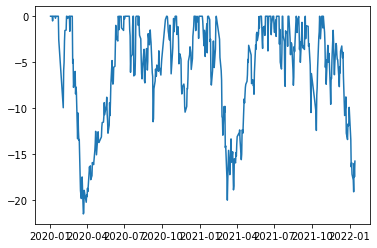

sh: 1: netstat: not found


In [192]:
# 最大回撤
def drawdown(nav):
    acc_return = (nav['adj_nav'][:-1] / nav['adj_nav'][-1] - 1) * 100
    maxhis = acc_return[::-1].cummax()[::-1]
    drawdown = ((acc_return + 100) / (maxhis + 100) - 1) * 100
    plt.plot(nav['date'][:-1], drawdown)
    return pd.DataFrame({'date':nav['date'][:-1], 'drawdown':drawdown})
drawdown(nav)

In [196]:
def info(nav):
    active = nav['adj_pctchg'] - nav['benchmark']
    track_error = active[:-1].std() * sqrt(250)
    info = active[:-1].mean() / track_error * 250
    return round(track_error, 2), round(info, 2)
info(navy)

(24.57, 1.39)

In [205]:
((nav[nav['adj_pctchg'] < 0]['adj_pctchg'] - (nav[nav['adj_pctchg'] < 0]['adj_pctchg']).mean())**2).sum() / nav

407.1397190686472

In [207]:
def dr(nav):
    downret = nav[nav['adj_pctchg'] < 0]['adj_pctchg']
    mean = downret.mean()
    sumsquard = ((downret - mean) ** 2).sum()
    T = nav.count()[0] - 1
    return round(sqrt(sumsquard / T * 250), 2)
dr(navy)

13.35

In [208]:
def max_decline(nav):
    return nav['adj_pctchg'].min()
max_decline(navy)

-4.963440550372795

In [213]:
nav['adj_pctchg'][::-1]

code
000126.OF    3.016241
000126.OF    0.119651
000126.OF    0.984183
000126.OF    1.225200
000126.OF   -0.508906
               ...   
000126.OF   -0.742779
000126.OF   -1.572048
000126.OF    3.801449
000126.OF   -1.723093
000126.OF    2.064288
Name: adj_pctchg, Length: 495, dtype: float64

In [214]:
def keep_decline(nav):
    navlist = nav['adj_pctchg'][::-1]
    temp = 0    # 当前连跌次数
    maxd = 0    # 历史最大的连跌次数
    for i in range(0, len(nav)):
        if navlist[i] < 0:
            temp += 1
            if temp > maxd:
                maxd = temp
        else:
            temp = 0
    return maxd
keep_decline(navy)

7

In [220]:
def var(nav):
    return round(nav['adj_pctchg'].quantile(0.05), 2)
var(navy)

-3.24

In [222]:
def xgxs(nav):
    return nav['adj_pctchg'].corr(nav['benchmark'])
xgxs(navy)

0.8310188815894727

In [11]:
def period_return(nav, bgndt=BDT, enddt=DT): #截止日期默认为最新日期
    _nav = nav[nav['date'].between(bgndt, enddt)]
    _nav['adj_pctchg'] = _nav['adj_pctchg'] / 100 + 1
    returnmn = (_nav.groupby('code')['adj_pctchg'].prod()[0] - 1) * 100
    cnt = _nav.count()[0]
    ann_returnmn = (1 + returnmn/100) ** (250 / cnt) * 100 - 100    
    return round(returnmn, 2), round(ann_returnmn, 2)
period_return(nav)

/tmp/ipykernel_7906/2253110990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _nav['adj_pctchg'] = _nav['adj_pctchg'] / 100 + 1


(30.1, 31.09)

sh: 1: netstat: not found


In [12]:
# sharpe
mean = (nav['adj_pctchg'] - nav['riskfree']).agg(['mean', 'std'])
sqrt(250) * mean['mean'] / mean['std']

1.6218372033266695

In [108]:
def vol(nav, bgndt=BDT, enddt=DT):
    _nav = nav[nav['date'].between(bgndt, enddt)] 
    vol = _nav.groupby('code')['adj_pctchg'].std()[0]
    return round(vol, 2), round(vol * sqrt(250), 2)
vol(nav)

(2.17, 34.37)

sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found


In [14]:
def track_error(nav, bgndt=BDT, enddt=DT):
    _nav = nav[nav['date'].between(bgndt, enddt)]
    _nav['active'] = (_nav['adj_pctchg'] - _nav['benchmark']) / 100
    std = _nav.groupby('code')['active'].std()[0]
    mean = _nav.groupby('code')['active'].mean()[0]
    track_error = std * sqrt(250) * 100
    return round(track_error, 2), round(mean / track_error * 250 * 100, 2)
track_error(nav, DT - timedelta(6))

/tmp/ipykernel_7906/1505528737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _nav['active'] = (_nav['adj_pctchg'] - _nav['benchmark']) / 100


(15.03, -11.97)

In [15]:
def drawdown(nav, bgndt=BDT, enddt=DT):
    _nav = nav[nav['date'].between(bgndt, enddt)]
    _nav['acc_return1'] = (_nav['adj_nav'] / _nav.groupby('code')['adj_nav'].last() - 1) * 100
    _nav['drawdown'] = (_nav['adj_nav'] / _nav['adj_nav'][::-1].cummax()[::-1] - 1) * 100
    return _nav[['date', 'drawdown']]
dd = drawdown(nav)

/tmp/ipykernel_7906/2386675360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _nav['acc_return1'] = (_nav['adj_nav'] / _nav.groupby('code')['adj_nav'].last() - 1) * 100
/tmp/ipykernel_7906/2386675360.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _nav['drawdown'] = (_nav['adj_nav'] / _nav['adj_nav'][::-1].cummax()[::-1] - 1) * 100


In [17]:
import random
import matplotlib.pyplot as plt

In [18]:
def coin_clip():
    return random.randint(0, 1)

sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netstat: not found
sh: 1: netst

In [30]:
coin_clip()

1

In [44]:
def monte_carlo(n):
    list1 = []
    results = 0
    for i in range(0, n):
        flip_result = coin_clip()
        results += flip_result

        prob_value = results / (i + 1)

        list1.append(prob_value)

        plt.axhline(y=0.5, color='r', linestyle='-')
        plt.xlabel('Iterations')
        plt.ylabel('Probability')
        plt.plot(list1)
    return results / n

Final Value : 0.5068


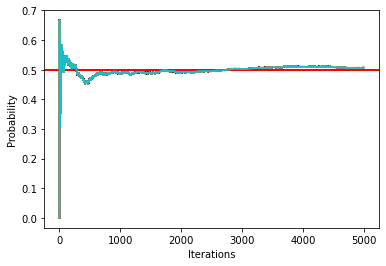

In [46]:
answer = monte_carlo(5000)
print('Final Value :', answer)

In [47]:
1.4674 * (1 - 0.1725)

1.2142735